# MVA - Homework 1 - Reinforcement Learning (2022/2023)

**Name:** DI PIAZZA Théo

## Instructions

* The deadline is **November 10 at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/l4y5ubadwj64mb/post/6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [85]:
# Connect to google colab to save the script as HTML as the end of the execution
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [87]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [88]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt

# Preparation

In the coding exercises, you will use a *grid-world* MDP, which is represented in Python using the interface provided by the [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.


In [89]:
from rlberry.envs import GridWorld

def get_env():
  """Creates an instance of a grid-world MDP."""
  env = GridWorld(
      nrows=5,
      ncols=7,
      reward_at = {(0, 6):1.0},
      walls=((0, 4), (1, 4), (2, 4), (3, 4)),
      success_probability=0.9,
      terminal_states=((0, 6),)
  )
  return env

def render_policy(env, policy=None, horizon=50):
  """Visualize a policy in an environment

  Args:
    env: GridWorld
        environment where to run the policy
    policy: np.array
        matrix mapping states to action (Ns).
        If None, runs random policy.
    horizon: int
        maximum number of timesteps in the environment.
  """
  env.enable_rendering()
  state = env.reset()                       # get initial state
  for timestep in range(horizon):
      if policy is None:
        action = env.action_space.sample()  # take random actions
      else:
        action = policy[state]
      next_state, reward, is_terminal, info = env.step(action)
      state = next_state
      if is_terminal:
        break
  # save video and clear buffer
  env.save_video('./videos/gw.mp4', framerate=5)
  env.clear_render_buffer()
  env.disable_rendering()
  # show video
  show_video('./videos/gw.mp4')


In [90]:
# Create an environment and visualize it
env = get_env()
render_policy(env)  # visualize random policy

# The reward function and transition probabilities can be accessed through
# the R and P attributes:
print(f"Shape of the reward array = (S, A) = {env.R.shape}")
print(f"Shape of the transition array = (S, A, S) = {env.P.shape}")
print(f"Reward at (s, a) = (1, 0): {env.R[1, 0]}")
print(f"Prob[s\'=2 | s=1, a=0]: {env.P[1, 0, 2]}")
print(f"Number of states and actions: {env.Ns}, {env.Na}")

# The states in the griworld correspond to (row, col) coordinates.
# The environment provides a mapping between (row, col) and the index of
# each state:
print(f"Index of state (1, 0): {env.coord2index[(1, 0)]}")
print(f"Coordinates of state 5: {env.index2coord[5]}")

Shape of the reward array = (S, A) = (31, 4)
Shape of the transition array = (S, A, S) = (31, 4, 31)
Reward at (s, a) = (1, 0): 0.0
Prob[s'=2 | s=1, a=0]: 0.04999999999999999
Number of states and actions: 31, 4
Index of state (1, 0): 6
Coordinates of state 5: (0, 6)


# Part 1 - Dynamic Programming

## Question 1.1

Consider a general MDP with a discount factor of $\gamma < 1$. Assume that the horizon is infinite (so there is no termination). A policy $\pi$ in this MDP
induces a value function $V^\pi$. Suppose an affine transformation is applied to the reward, what is
the new value function? Is the optimal policy preserved?



### **Answer**

To start, let's consider :
- A policy $\pi = (d_t)_{t\geq0}$, which induces a value faction $V_\pi$.
- $\forall (s,a) \in (S, A)$, the new reward $r_{aff}(s,a)$, obtained after an affine transformation of the original reward $r(s,a)$ such that : $r_{aff}(s,a) = A*r(s,a)+B$

<br>

We know by definition that :     
$$\forall s \in S, \ V^{\pi}(s) =  \mathbb{E}[\sum_{t = 0}^{\infty} \gamma^{t} . r(s_t, d_t(s_t)) \ \vert \ s_0=s, \ \pi] $$

<br>

Then, if we define $V^{\pi}_{aff}$ the new value function obtained after an affine transformation applied to the reward :


$$\forall s \in S, \ V^{\pi}_{aff}(s) =  \mathbb{E}[\sum_{t = 0}^{\infty} \gamma^{t} . r_{affine}(s_t, d_t(s_t)) \ \vert \ s_0=s, \ \pi] = 
\mathbb{E}[\sum_{t = 0}^{\infty} \gamma^{t} . A*r(s_t, d_t(s_t))+B \ \vert \ s_0=s, \ \pi] = A \ \mathbb{E}[\sum_{t = 0}^{\infty} \gamma^{t} . r(s_t, d_t(s_t)) \ \vert \ s_0=s, \ \pi] + B\sum_{t = 0}^{\infty} \gamma^{t} = A \ V^{\pi}(s)+\frac{B}{1-γ}$$


<br>

Finally, if we consider $\pi^{*}$ the optimal policy which induces the value function $V^{\pi^{*}}$, we have that for any policy $\pi$ :


$$V^{\pi^*}_{aff}(s) \geq V^{\pi}_{aff} \iff A \ V^{\pi^*}(s)+\frac{B}{1-γ} = A \ V^{\pi}(s)+\frac{B}{1-γ} \iff A \ (V^{\pi^*}(s)-V^{\pi}(s)) \geq 0 \iff A \geq 0$$

<br>

Hence, the optimal policy is preserved if and only if $A \geq 0$.

## Question 1.2

Consider an infinite-horizon $\gamma$-discounted MDP. We denote by $Q^*$ the $Q$-function of the optimal policy $\pi^*$. Prove that, for any function $Q(s, a)$ (which is **not** necessarily the value function of a policy), the following inequality holds for any state $s$:

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

where $||Q^*-Q||_\infty = \max_{s, a} |Q^*(s, a) - Q(s, a)|$ and $\pi_Q(s) \in \arg\max_a Q(s, a)$. Can you use this result to show that any policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal?

### **Answer**

To start, it's recalled that :

- $$\forall s \in S, \ \mathcal{T}^{\pi_Q}V^{*}(s) = r(s,\pi_Q(s)) + \gamma \sum_{s'} p(s' \vert s,\pi_Q(s))V^{*}(s')$$ $$= r(s,\pi_Q(s)) + \gamma \sum_{s'} p(s' \vert s,\pi_Q(s))Q^{*}(s', \pi_Q(s'))$$ $$= Q^{*}(s, \pi_Q(s))$$

- $$\forall s \in S, \ \mathcal{T}^{\pi_Q}V^{\pi_Q}(s) = V^{\pi_Q}(s)$$

<br>

Then it can be showned that : 

$\forall (s, a) \in S.A$ : 

$$| V^{\pi_Q}(s) - V^{*}(s) | = | V^{\pi_Q}(s) - Q^{*}(s, \pi_Q(s)) + Q^{*}(s, \pi_Q(s)) - Q(s, a) + Q(s, a) - V^{*}(s) |$$

$$ \leq | V^{\pi_Q}(s) - Q^{*}(s, \pi_Q(s)) | + | Q^{*}(s, \pi_Q(s)) - Q(s, a) | + | Q(s, a) - V^{*}(s) |$$

<br>

Where :

- $| V^{\pi_Q}(s) - Q^{*}(s, \pi_Q(s)) | = | \mathcal{T}^{\pi_Q}V^{\pi_Q}(s) - \mathcal{T}^{\pi_Q}V^{*}(s) | \leq γ||V^{\pi_Q}-V^{*}||_{\infty}$
- $| Q^{*}(s, \pi_Q(s)) - Q(s, a) | \leq \max_{a, s} | Q^{*}(s, a) - Q(s, a) | = ||Q^{*}-Q||_{\infty}$
- $| Q(s, a) - V^{*}(s) | = | Q(s, a) -  Q^{*}(s, \pi_Q(s)) | \leq ||Q^{*}-Q||_{\infty}$

<br>

Hence, finally : 

$$ ||V^{\pi_Q}-V^{*}||_{\infty} \leq \gamma||V^{\pi_Q}-V^{*}||_{\infty}+ 2||Q^{*}-Q||_{\infty} \iff ||V^{\pi_Q}-V^{*}||_{\infty} \leq \frac{2}{1-\gamma}||Q^{*}-Q||_{\infty}$$

<br>

Then since $V^{*}$ is the value function of the optimal policy, it can be written that $\forall s \in S$ : 

$$ V^{\pi_Q}(s)-V^{*}(s) \geq -\frac{2}{1-\gamma}||Q^{*}-Q||_{\infty}$$

## Question 1.3

In this question, you will implement and compare the policy and value iteration algorithms for a finite MDP. 

Complete the functions `policy_evaluation`, `policy_iteration` and `value_iteration` below.


Compare value iteration and policy iteration. Highlight pros and cons of each method.

### **Answer**

Pros and cons of each method :

<br>

#### **Policy Iteration**:

**Pros**: Converge in a finite number of iterations.

**Cons**:  each iteration requires a full policy evaluation and it might be expensive.

<br>

##### **Value Iteration**:

**Pros**: each iteration is very computationally efficient.

**Cons**: convergence is only asymptotic.



In [91]:
# Link : http://incompleteideas.net/book/ebook/node41.html
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    # Number of states, actions
    Ns, Na = R.shape

    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #
    value_function = np.zeros(Ns)

    # 2 possibles computation : one with precision criterium, and one without
    
    # [1/2] : Direct computation without precision criterium
    if(tol==0):

      # Identity matrix (Ns.Ns)
      matrix_I = np.eye(Ns)

      # Compute matrix P and R 
      P_direct, R_direct = np.zeros([Ns, Ns]), np.zeros(Ns)

      # Fill these matrixes
      for s in range(Ns):
        P_direct[s] = P[s, policy[s], :]
        R_direct[s] = R[s, policy[s]]

      # Compute value function
      value_function = np.linalg.inv(matrix_I - gamma*P_direct) @ R_direct # Matmul product

      return value_function

    # [2/2] : Iterative computation with precision criterium
    elif(tol > 0):

      criterium = False

      while(not criterium):

        current_value_function = value_function.copy()

        for s in range(Ns):
          value_function[s] = R[s,policy[s]] + gamma*P[s,policy[s],:]@value_function

        # Update criterium and value function
        criterium = ( max(abs(current_value_function - value_function)) < tol )

      return value_function
    # ====================================================

In [92]:
"""
  The policy iteration algorithm generates a sequences of policies with non-decreasing
  performance. And it converges to the optimal policy in a finite number of iteraties.
"""

def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V = np.zeros(Ns)
    policy = np.ones(Ns, dtype=int)
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #

    stop_criterium = False

    # At each iteration
    while(not stop_criterium):

      V_policy = V.copy()

      # Policy evaluation : given policy, compute value function
      V = policy_evaluation(P, R, policy, gamma, tol)

      # Policy improvement : compute the greedy policy
      policy = np.argmax(R+gamma*(P@V), axis=1)

      stop_criterium = ((V == V_policy).all())

    # ====================================================
    return policy, V

In [93]:
"""
  Value iteration is a method of computing an optimal MDP policy and its value.
"""

def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q]
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #

    stop_criterium = False # Criterium to stop iteration
    V = np.zeros(Ns) # Value function associated to Q-function

    while(not stop_criterium):

      # value contains value function of previous iteration
      value = V.copy()

      # Compute Q-function of current iteration
      Q = R+gamma*(P@V)
      # Stock it for visualization
      Qfs.append(Q)
      # Compute the greedy policy of current iteration
      greedy_policy = np.argmax(Q, axis=1)

      # Compute new value function associated to the current Q-function, and update stop criterium
      V = np.max(Q, axis = 1)
      stop_criterium = ( max(abs(V-value)) < tol )

    # ====================================================
    return Q, greedy_policy, Qfs

### Testing your code

[VI]Greedy policy: 



[PI]final policy: 


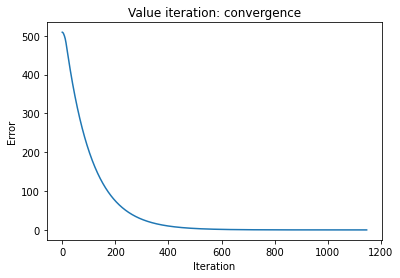

In [94]:
# Parameters
tol = 1e-5
gamma = 0.99

# Environment
env = get_env()

# run value iteration to obtain Q-values
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)

# render the policy
print("[VI]Greedy policy: ")
render_policy(env, VI_greedypol)

# compute the value function of the greedy policy using matrix inversion
# ====================================================
# YOUR IMPLEMENTATION HERE 
# compute value function of the greedy policy
#

greedy_V = policy_evaluation(env.P, env.R, VI_greedypol, gamma, tol)

# ====================================================

# show the error between the computed V-functions and the final V-function
# (that should be the optimal one, if correctly implemented)
# as a function of time
final_V = all_qfunctions[-1].max(axis=1)
norms = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions]
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence")

#### POLICY ITERATION ####
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)
print("\n[PI]final policy: ")
render_policy(env, PI_policy)

## Uncomment below to check that everything is correct
assert np.allclose(PI_policy, VI_greedypol),\
    "You should check the code, the greedy policy computed by VI is not equal to the solution of PI"
assert np.allclose(PI_V, greedy_V),\
    "Since the policies are equal, even the value function should be"

plt.show()

# Part 2 - Tabular RL

## Question 2.1

The code below collects two datasets of transitions (containing states, actions, rewards and next states) for a discrete MDP.

For each of the datasets:

1. Estimate the transitions and rewards, $\hat{P}$ and $\hat{R}$.
2. Compute the optimal value function and the optimal policy with respect to the estimated MDP (defined by $\hat{P}$ and $\hat{R}$), which we denote by $\hat{\pi}$ and $\hat{V}$.
3. Numerically compare the performance of $\hat{\pi}$ and $\pi^\star$ (the true optimal policy), and the error between $\hat{V}$ and $V^*$ (the true optimal value function).

Which of the two data collection methods do you think is better? Why?

### **Answer**

$\Longrightarrow$ Concerning the comparison of the **performances of the different policies**, we notice that the policy obtained with dataset 2 (*uniform sampling*) evolves almost all the time towards the optimal solution. On the other hand, the policy obtained with dataset 1 (*random sampling*) does not evolve towards the solution, especially when the number of samples is too small.

<br>

$\Longrightarrow$ Concerning the comparison of the error between the **estimated and exact function values**, it can be seen that the errors are much smaller (both L1 and L-Inf norm) for the function value estimated by dataset 2 (*uniform sampling*) than dataset 1 (*random sampling*).

<br>

$\Longrightarrow$ For these reasons, the method that seems to be the most robust and efficient for this kind of problem is **method 2 (by uniformly sampling states and actions)**.

In [95]:
def get_random_policy_dataset(env, n_samples):
  """Get a dataset following a random policy to collect data."""
  states = []
  actions = []
  rewards = []
  next_states = []
  
  state = env.reset()
  for _ in range(n_samples):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    # update state
    state = next_state
    if is_terminal:
      state = env.reset()

  dataset = (states, actions, rewards, next_states)
  return dataset

def get_uniform_dataset(env, n_samples):
  """Get a dataset by uniformly sampling states and actions."""
  states = []
  actions = []
  rewards = []
  next_states = []
  for _ in range(n_samples):
    state = env.observation_space.sample()
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.sample(state, action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)

  dataset = (states, actions, rewards, next_states)
  return dataset


# Collect two different datasets
num_samples = 1000
env = get_env()
dataset_1 = get_random_policy_dataset(env, num_samples)
dataset_2 = get_uniform_dataset(env, num_samples)


# Item 3: Estimate the MDP with the two datasets; compare the optimal value
# functions in the true and in the estimated MDPs

# The answer to these questions is in the cells below.

In [96]:
# To start, we define a function getMatrixPR which returns P_hat and R_hat, for a given environment and dataset.

def getMatrixPR(env, dataset):
  """
    Args:
        env: GridWorld environment
        dataset: tuple
            containing (states from, actions, rewards, states to)
    Return:
        P_hat: np.array
            Estimation of transition (Ns, Na, Ns)
        R_hat : np.array
            Estimation of rewards (Ns, Na)
  """

  # Get number of states and number of actions
  Ns, Na = env.S, env.A

  # Initialize arrays that will be used to compute P_hat and R_hat
  occurenceMatrix, P_hat = np.zeros((Ns, Na, Ns)), np.zeros((Ns, Na, Ns))
  R_sum, R_hat = np.zeros((Ns, Na)), np.zeros((Ns, Na))

  # For each sample of the MDP : 
  # 1 - Count number of transition (FROM state i -> TO state j WITH action a)
  # 2 - Sum rewards for each transition (FROM state i WITH action a)

  for s_i, s_j, a, r in zip(dataset[0], dataset[3], dataset[1], dataset[2]):
    
    # Compute number of times the transition from state i to j with action a
    occurenceMatrix[s_i, a, s_j] += 1

    # For each (s_i, a), sum all rewards
    R_sum[s_i, a] += r


  # Compute number of occurences per (state i, action a)
  occurenceActions = np.sum(occurenceMatrix, axis=2) # Sum over action j

  # For each state i, action a, to state j : compute P_hat and R_hat

  for s_i in range(Ns):
    for a in range(Na):
      for s_j in range(Ns):

        # Check if number of actions is null to not divide by 0
        if(occurenceActions[s_i, a] != 0):

          # Compute P_hat(state i, action a, state j)
          P_hat[s_i, a, s_j] = occurenceMatrix[s_i, a, s_j]/occurenceActions[s_i, a]

      # Compute R_hat
      # Check if number of actions is null to not divide by 0
      if(occurenceActions[s_i, a] != 0):
        R_hat[s_i, a] += R_sum[s_i, a]/occurenceActions[s_i, a]

  return P_hat, R_hat

In [97]:
# Initialize parameters
gamma = 0.9

# Compute P_hat and R_hat for dataset_1
P_hat1, R_hat1 = getMatrixPR(env, dataset_1)
P_hat2, R_hat2 = getMatrixPR(env, dataset_2)

# Compute policy and value function for the 2 datasets
policy1, V1 = policy_iteration(P_hat1, R_hat1, gamma, 0)
policy2, V2 = policy_iteration(P_hat2, R_hat2, gamma, 0)

# Compute true optimal policy and value function
policy_true, V_true = policy_iteration(env.P, env.R, gamma, 0)

In [98]:
# Compare values of true optimal value function and estimations with L1 and L-inf norm.

# For dataset 1 (random)
d1_L1 = max(abs(V_true - V1))
d1_LInf = sum(abs(V_true - V1))

# For dataset 2 (uniform)
d2_L1 = max(abs(V_true - V2))
d2_LInf = sum(abs(V_true - V2))

print(f"Error between true and estimated value functions:\n")

print(f"- Dataset 1 (random):\nEstimated with L1 norm: {d1_L1:.2f}.")
print(f"Estimaed estimated with L-Inf norm: {d1_LInf:.2f}.\n")

print(f"- Dataset 2 (uniform):\nEstimated with L1 norm: {d2_L1:.2f}.")
print(f"Estimated with L-Inf norm: {d2_LInf:.2f}.")

Error between true and estimated value functions:

- Dataset 1 (random):
Estimated with L1 norm: 8.81.
Estimaed estimated with L-Inf norm: 14.47.

- Dataset 2 (uniform):
Estimated with L1 norm: 0.24.
Estimated with L-Inf norm: 3.90.


In [99]:
# Compare performance of policies

# For dataset 1
print(f"Policy of dataset 1 with {num_samples} samples (random).")
render_policy(env, policy1)

# For dataset 2
print(f"\nPolicy of dataset 2 with {num_samples} samples (uniform).")
render_policy(env, policy2)

# For true policy
print(f"\nTrue policy with {num_samples} samples.")
render_policy(env, policy_true)

Policy of dataset 1 with 1000 samples (random).



Policy of dataset 2 with 1000 samples (uniform).



True policy with 1000 samples.


## Question 2.2

Suppose that $\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair. This means that, for each $(s,a)$, we have $N$ samples $\{(s_1',r_1, \dots, s_N', r_N\}$, where $s_i' \sim P(\cdot | s,a)$ and $r_i \sim R(s,a)$ for $i=1,\dots,N$, and
$$ \hat{P}(s'|s,a) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(s_i' = s'), $$
$$ \hat{R}(s,a) = \frac{1}{N}\sum_{i=1}^N r_i.$$
Suppose that $R$ is a distribution with support in $[0,1]$. Let $\hat{V}$ be the optimal value function computed in the empirical MDP (i.e., the one with transitions $\hat{P}$ and rewards $\hat{R}$). For any $\delta\in(0,1)$, derive an upper bound to the error

$$ \| \hat{V} - V^* \|_\infty $$

which holds with probability at least $1-\delta$.

**Note** Your bound should only depend on deterministic quantities like $N$, $\gamma$, $\delta$, $S$, $A$. It should *not* dependent on the actual random samples.

**Hint** The following two inequalities may be helpful.

1. **A (simplified) lemma**. For any state $\bar{s}$,

$$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

2. **Hoeffding's inequality**. Let $X_1, \dots X_N$ be $N$ i.i.d. random variables bounded in the interval $[0,b]$ for some $b>0$. Let $\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$ be the empirical mean. Then, for any $\epsilon > 0$,

$$ \mathbb{P}(|\bar{X} - \mathbb{E}[\bar{X}]| > \epsilon) \leq 2e^{-\frac{2N\epsilon^2}{b^2}}.$$

### **Answer**

From the simplified Lemma number 1, it can be shown that : 

$$ \| \hat{V} - V^* \|_\infty \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

Then, from the triangular inequality :

$$ \| \hat{V} - V^* \|_\infty \leq \frac{1}{1-\gamma}(\max_{s,a} \left| R(s,a) - \hat{R}(s,a)\right| + \max_{s,a} \left| \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|)$$

In this question, it's needed to show that :  

$$P(| \hat{V} - V^* \|_\infty \geq ϵ ) \leq \delta$$

Hence, we need to consider probabilities to get the final results.

So if we consider that :

$$\epsilon \leq \| \hat{V} - V^* \|_\infty \leq \frac{1}{1-\gamma}(\max_{s,a} \left| R(s,a) - \hat{R}(s,a)\right| + \max_{s,a} \left| \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|)$$

Hence, we have either that :

$$\frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a)\right| > \frac{\epsilon}{2}$$ or $$\frac{\gamma}{1-\gamma}\max_{s,a} \left| \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right| > \frac{\epsilon}{2}$$

Then, with probabilities :

$$P(|| \hat{V} - V^* \|_\infty \geq ϵ ) \leq P(\frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a)\right| > \frac{\epsilon}{2}) + P(\frac{\gamma}{1-\gamma}\max_{s,a} \left| \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|) > \frac{\epsilon}{2})$$

Then, it comes that : 

$$P(|| \hat{V} - V^* \|_\infty \geq ϵ ) \leq P(\bigcup_{s, a} \left|R(s,a) - \hat{R}(s,a)\right| > \frac{\epsilon (1-\gamma)}{2}) + P(\bigcup_{s, a}\left| \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right| > \frac{\epsilon (1-\gamma)}{2\gamma})$$

$$\leq \sum_{s, a} [ \ P(\left|R(s,a) - \hat{R}(s,a)\right| > \frac{\epsilon (1-\gamma)}{2}) + P(\left| \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right| > \frac{\epsilon (1-\gamma)}{2\gamma}) \ ]$$

<br>
Now, the Hoeffding's inequality will be used to find an upper bound.

For the first term in the sum, we can have this upper bound :

$$P(\left|R(s,a) - \hat{R}(s,a)\right| > \frac{\epsilon (1-\gamma)}{2}) \leq 2e^{-\frac{2N\epsilon^2 (1-\gamma)^2}{4}} = 2e^{-\frac{N\epsilon^2(1-\gamma)^2}{2}}$$

To have an upper bound for the second term, we know that $R$ is a distribution with support in $[0,1]$, and for any policy $\pi$ :

$$0 \leq V^{\pi}(s) = \mathbb{E}[\sum_{t}\gamma^t R(s_t, d_t(at) | s_0=s, \pi] \leq \mathbb{E}[\sum_{t}\gamma^t | s_0=s, \pi] = \frac{1}{1-\gamma}$$

Hence,

$$0 \leq V^{\pi}(s) \leq V^{*}(s) \leq \frac{1}{1-\gamma}$$

Then :

$$\mathbb{E}[\mathbb{1}(s_i' = s') V^{*}(s')] = V^{*}(s')P(s'|s,a) \in [0, \frac{1}{1-\gamma}]$$

We can now find an upper bound to the second term of the sum :

$$P(\left| \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right| > \frac{\epsilon (1-\gamma)}{2\gamma}) \leq \sum_{s'}P(\left| (P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right| > \frac{\epsilon (1-\gamma)}{2\gamma})$$

$$ \leq 2|S|e^{-\frac{N\epsilon^2(1-\gamma)^4}{2\gamma^2 |S|^2}}$$

Finally :

$$P(|| \hat{V} - V^* \|_\infty \geq ϵ ) \leq 2|S||A|e^{-\frac{N\epsilon^2(1-\gamma)^2}{2}} + 2|S|^2|A|e^{-\frac{N\epsilon^2(1-\gamma)^4}{2\gamma^2 |S|^2}}$$
$$\leq 4|S||A|max(e^{-\frac{N\epsilon^2(1-\gamma)^2}{2}}, \ |S|e^{-\frac{N\epsilon^2(1-\gamma)^4}{2\gamma^2 |S|^2}}) $$

And to conlude, with $\epsilon(N, \gamma, \delta, S, A) = max(\sqrt{\frac{2}{N(1-\gamma)^2}log(\frac{4|A||S|}{\delta})}, \ \sqrt{\frac{2\gamma^2|S|^2}{N(1-\gamma)^4}log(\frac{4|A||S|^2}{\delta})} \ )$ :

$$|| \hat{V} - V^* \|_\infty < \epsilon(N, \gamma, \delta, S, A) \mbox{, with probability at least} 1-\delta$$.

## Question 2.3

Suppose once again that we are given a dataset of $N$ samples in the form of tuples $(s_i,a_i,s_i',r_i)$. We know that each tuple contains a valid transition from the true MDP, i.e., $s_i' \sim P(\cdot | s_i, a_i)$ and $r_i \sim R(s_i,a_i)$, while the state-action pairs $(s_i,a_i)$ from which the transition started can be arbitrary.

Suppose we want to apply Q-learning to this MDP. Can you think of a way to leverage this offline data to improve the sample-efficiency of the algorithm? What if we were using SARSA instead?

### **Answer**

For the **Q-learning algorithm** which is a model-free RL algorithm, $Q(s,a)$ is updated only when $(s,a)$ is visited. In **dynamic-Q learning**, $Q(s,a)$ is updated every time $(s,a)$ is queried from the memory. Hence, it's not needed to revisit $(s,a)$ to update $Q(s,a)$. Hence it speeds up the algorithm. 

Therefore, **dynamic-Q learning** should be an efficient way to leverage this offline data to improve the sample-efficiency of the algorithm

However, **SARSA** is on-policy since at each update of $Q(s,a)$, the Q-value of the next state will be used. That's why SARSA would not work since in our case, the update is made with the sample of the dataset (off-policy).

# Part 3 - RL with Function Approximation

## Question 3.1

Given a datset $(s_i, a_i, r_i, s_i')$ of (states, actions, rewards, next states), the Fitted Q-Iteration (FQI) algorithm proceeds as follows:


* We start from a $Q$ function $Q_0 \in \mathcal{F}$, where $\mathcal{F}$ is a function space;
* At every iteration $k$, we compute $Q_{k+1}$ as:

$$
Q_{k+1}\in\arg\min_{f\in\mathcal{F}} \frac{1}{2}\sum_{i=1}^N
\left(
  f(s_i, a_i) - y_i^k
\right)^2 + \lambda \Omega(f)
$$
where $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$, $\Omega(f)$ is a regularization term and $\lambda > 0$ is the regularization coefficient.


Consider FQI with *linear* function approximation. That is, for a given feature map $\phi : S \rightarrow \mathbb{R}^d$, we consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a$ for $\theta_a\in\mathbb{R}^d$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. Derive the *closed-form* update to find $\theta_{k+1}$, using $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.

### **Answer**

To start, we'll define : 

$$Q_\theta(s,a) = \phi(s)^T\theta_a = \phi(s)^T\theta M_{a}$$

where $M_{a} \in \mathbb{R}^A$ defined such as $\forall i \in \{1, .., A\} : (M_{a})_{i}=1$ if $a_{i}=a$, 0 otherwise.

Therefore, we have the two following results :

$$M_{a} M_{a}^{T} = I_{A} \ (\in \mathbb{R}^{A.A})$$
$$\forall i \in \{1, .., A\}, \  (M_{a}^{T} M_{a})_{i} = \mathbb{1}_{a_i=a} \ (\in \mathbb{R})$$

-----------------

Hence, the function to minimize becomes :

$$ g : \theta → \frac{1}{2} \sum_{i=1}^{N} (\phi(s_i)^T\theta M_{a_i}-y_{i}^k)^2 +\frac{\lambda}{2} \sum_{a \in A}M_a^T \theta ^T \theta M_a $$

which is convex and coercive. 

-----------------

Then, the solution of the optimization problem can be found by finding the value of the parameter $\theta$ where the gradient of $g$ is null.

$$\nabla g(\theta)=\sum_{i=1}^N \phi(s_i) M_{a_i}^T (\phi(s_i)^T \theta M_{a_i} - y_i^k) + \lambda \theta M_a M_a^T$$
$$=\sum_{i=1}^N \phi(s_i) M_{a_i}^T (\phi(s_i)^T \theta M_{a_i} - y_i^k) + \lambda \theta$$

Hence, $\theta_{k+1}$ is the value of $\theta$ where gradient is null at this point :

$\nabla g(\theta)=0 \iff \lambda \theta_{k+1} +  \sum_{i=1}^N \phi(s_i) M_{a_i}^T \phi(s_i)^T \theta_{k+1} M_{a_i} = \sum_{i=1}^N \phi(s_i) M_{a_i}^T y_i^k$

Then, it comes that :

$$(\lambda \theta_{k+1})_{a} +  \sum_{i=1}^N \phi(s_i) M_{a_i}^T \phi(s_i)^T \theta_{k+1} M_{a_i} M_{a} = \sum_{i=1}^N \phi(s_i) M_{a_i}^T y_i^k M_{a}$$

$$\iff (\lambda \theta_{k+1})_{a} +  \sum_{i=1}^N \mathbb{1}_{a_i=a}\phi(s_i)(\phi(s_i)^T (\theta_{k+1})_a) = \sum_{i=1}^N \mathbb{1}_{a_i=a} \phi(s_i) y_i^k$$

$$\iff (\lambda I_d +  \sum_{i=1}^N \mathbb{1}_{a_i=a}\phi(s_i)\phi(s_i)^T)(\theta_{k+1})_{a} = \sum_{i=1}^N \mathbb{1}_{a_i=a} \phi(s_i) y_i^k$$

So finally, by matrix inversion :

$$(\theta_{k+1})_{a} = (\lambda I_d +  \sum_{i=1}^N \mathbb{1}_{a_i=a}\phi(s_i)\phi(s_i)^T)^{-1} \sum_{i=1}^N \mathbb{1}_{a_i=a} \phi(s_i) y_i^k$$


## Question 3.2

The code below creates a larger gridworld (with more states than the one used in the previous questions), and defines a feature map. Implement linear FQI to this environment (in the function `linear_fqi()` below), and compare the approximated $Q$ function to the optimal $Q$ function computed with value iteration.

Can you improve the feature map in order to reduce the approximation error?

### **Answer**

To improve the feature map, we can try different values of parameters of the function GridWorldFeatureMap : (dim: Feature dimension, sigma: RBF kernel bandwidth).

With default parameters $(15, 0.25)$, the agent doesn't achieve the terminal state.

By increasing the number of samples and changing values of parameters to $(200, 0.15)$, the results is better.

Moreover, dataset was generated with uniform samples.

Hence yes, the feature map can be improved in order to reduce the approximation error.

In [108]:
def get_large_gridworld():
  """Creates an instance of a grid-world MDP with more states."""
  walls = [(ii, 10) for ii in range(15) if (ii != 7 and ii != 8)]
  env = GridWorld(
      nrows=15,
      ncols=15,
      reward_at = {(14, 14):1.0},
      walls=tuple(walls),
      success_probability=0.9,
      terminal_states=((14, 14),)
  )
  return env


class GridWorldFeatureMap:
  """Create features for state-action pairs
  
  Args:
    dim: int
      Feature dimension
    sigma: float
      RBF kernel bandwidth
  """
  def __init__(self, env, dim=15, sigma=0.25):
    self.index2coord = env.index2coord
    self.n_states = env.Ns
    self.n_actions = env.Na
    self.dim = dim
    self.sigma = sigma

    n_rows = env.nrows
    n_cols = env.ncols

    # build similarity matrix
    sim_matrix = np.zeros((self.n_states, self.n_states))
    for ii in range(self.n_states):
        row_ii, col_ii = self.index2coord[ii]
        x_ii = row_ii / n_rows
        y_ii = col_ii / n_cols
        for jj in range(self.n_states):
            row_jj, col_jj = self.index2coord[jj]
            x_jj = row_jj / n_rows
            y_jj = col_jj / n_cols
            dist = np.sqrt((x_jj - x_ii) ** 2.0 + (y_jj - y_ii) ** 2.0)
            sim_matrix[ii, jj] = np.exp(-(dist / sigma) ** 2.0)

    # factorize similarity matrix to obtain features
    uu, ss, vh = np.linalg.svd(sim_matrix, hermitian=True)
    self.feats = vh[:dim, :]

  def map(self, observation):
    feat = self.feats[:, observation].copy()
    return feat

In [109]:
env = get_large_gridworld()
feat_map = GridWorldFeatureMap(env)

# Visualize large gridworld
render_policy(env)

# The features have dimension (feature_dim).
feature_example = feat_map.map(1) # feature representation of s=1
print(feature_example)

# Initial vector theta representing the Q function
theta = np.zeros((feat_map.dim, env.action_space.n))
print(theta.shape)
print(feature_example @ theta) # approximation of Q(s=1, a)

[-0.02850699  0.063555   -0.02169407 -0.06441918  0.04505794 -0.07537777
  0.08506473 -0.09325287  0.09644275 -0.00535101  0.11632395 -0.13074085
  0.00921342 -0.13853662  0.07118419]
(15, 4)
[0. 0. 0. 0.]


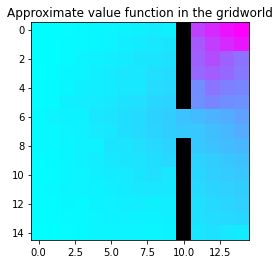

In [110]:
def linear_fqi(env, feat_map, num_iterations, lambd=0.1, gamma=0.95):
  """
  # Linear FQI implementation
  # TO BE COMPLETED
  """

  # get a dataset
  #    dataset = get_uniform_dataset(env, n_samples=...)
  # OR dataset = get_random_policy_dataset(env, n_samples=...)

  # Answer :

  # Initialize theta
  theta = np.zeros((feat_map.dim, env.Na))

  # Get dataset with uniform samples
  (states, actions, rewards, next_states) = get_uniform_dataset(env, n_samples = 2000) 

  # For each iteration of the algorithm
  for it in range(num_iterations):
    
    # Compute Q at iteration k (formula above) thanks to next_states and previous theta value
    Q = feat_map.map(next_states).T @ theta

    # Compute Y at iteration k thanks to Q (formula above)
    Y = gamma * np.max(Q, axis = 1) + rewards

    # For action possible, update theta[:, current_action]
    for current_action in np.unique(actions): 
      
      # Get index of current_action 
      current_index = np.array((actions == current_action), dtype = int) 
      # Update theta
      theta[:, current_action]  = np.linalg.inv(lambd*np.eye(feat_map.dim) + (feat_map.map(states)*current_index)@feat_map.map(states).T)@(feat_map.map(states)@(Y *current_index)).T
  
  return theta

# ----------------------------
# Environment and feature map
# ----------------------------
env = get_large_gridworld()
# you can change the parameters of the feature map, and even try other maps!
feat_map = GridWorldFeatureMap(env, dim=200, sigma=0.15)

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100)

# Compute and run greedy policy
Q_fqi = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi[ss, :] = state_feat @ theta

V_fqi = Q_fqi.max(axis=1)
policy_fqi = Q_fqi.argmax(axis=1)
render_policy(env, policy_fqi, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi)    
plt.imshow(img)
plt.title("Approximate value function in the gridworld")
plt.show()

In [113]:
# Command to save the file as HTML
! jupyter nbconvert --to html /content/drive/MyDrive/ENS_MVA/Reinforcement_Learning/HW1/RL_MVA_2022_Homework_1.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/ENS_MVA/Reinforcement_Learning/HW1/RL_MVA_2022_Homework_1.ipynb to html
[NbConvertApp] Writing 547313 bytes to /content/drive/MyDrive/ENS_MVA/Reinforcement_Learning/HW1/RL_MVA_2022_Homework_1.html


# End of the script

Thank you for reading !

Théo Di Piazza